In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import keplergl
import base64
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tracks_ready=pd.read_csv('C:/Users/Asus/Downloads/tracks_ready.csv',sep=',')

Откуда сперла

https://www.reneshbedre.com/blog/dbscan-python.html

In [3]:
tracks_ready_small=tracks_ready[['id','centroid_lon','centroid_lat','start_dttm','final_part_of_day_in_word','weekend','start_dttm_day']]

In [4]:
customers=np.unique(tracks_ready_small['id'])

In [5]:
ids=[]
clusters_list=[]
kneedle_list=[]
i=1
for id in customers:
    if len(tracks_ready_small[tracks_ready_small['id']==id])==1:
        ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        clusters_list.append([1]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        kneedle_list.append([0]*len(tracks_ready_small[tracks_ready_small['id']==id]))
    else:
        if len(tracks_ready_small[tracks_ready_small['id']==id])<5:
            nbrs = NearestNeighbors(n_neighbors = len(tracks_ready_small[tracks_ready_small['id']==id])).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        else:
            # n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
            nbrs = NearestNeighbors(n_neighbors = 5).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        # Find the k-neighbors of a point
        neigh_dist, neigh_ind = nbrs.kneighbors(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        # sort the neighbor distances (lengths to points) in ascending order
        # axis = 0 represents sort along first axis i.e. sort along row
        sort_neigh_dist = np.sort(neigh_dist, axis = 0)
        try:
            k_dist = sort_neigh_dist[:, 2]
        except IndexError:
            k_dist = sort_neigh_dist[:, 1]
        kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, 
                            curve = "concave", direction = "increasing", online=True)
        try:
            if kneedle.knee_y>0:
                kneedle_cuurent=kneedle.knee_y
            else:
                kneedle_cuurent=0.001
            clusters = DBSCAN(eps = kneedle_cuurent, min_samples = 1).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])    
            ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            clusters_list.append(clusters.labels_)
            kneedle_list.append([kneedle_cuurent]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        except TypeError:
            ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            clusters_list.append([1]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            kneedle_list.append([0]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        # get cluster labels - label each obs
        # check unique clusters
        #set(clusters.labels_)
        #print(Counter(clusters.labels_))    
        #p = sns.scatterplot(data = tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']], x = "centroid_lon", y = "centroid_lat", hue = clusters.labels_, legend = "full", palette = "deep")
        #plt.show()


c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\kneed\knee_locator.py:225: RuntimeWarning: invalid value encountered in true_divide
  return (a - min(a)) / (max(a) - min(a))
c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\signal\_peak_finding.py:74: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\signal\_peak_finding.py:75: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)
c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\signal\_peak_finding.py:74: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\signal\_peak_finding.py:75: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)
c:\User

In [6]:
import itertools
ids_list2 = list(itertools.chain(*ids))
clusters=list(itertools.chain(*clusters_list))
kn=list(itertools.chain(*kneedle_list))
clustering_result=pd.DataFrame(ids_list2,columns=['id'])
clustering_result['clusters']=clusters
clustering_result['kneedle']=kn
clustering_result['help']=1

In [7]:
tracks_ready_small['help']=1

c:\Users\Asus\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
checking_df=pd.pivot_table(tracks_ready_small,index='id',values='help',aggfunc=sum).merge(pd.pivot_table(clustering_result,index='id',values='help',aggfunc=sum),on='id')
checking_df['correct_result']=checking_df['help_x']==checking_df['help_y']
checking_df[checking_df['correct_result']==False]

,help_x,help_y,correct_result
id,,,


In [9]:
clustering_result.columns

Index(['id', 'clusters', 'kneedle', 'help'], dtype='object')

In [10]:
tracks_ready['clusters_settl']=clustering_result['clusters']
tracks_ready['kneedle']=clustering_result['kneedle']


In [11]:
def find_dist1(lat1,lon1,lat2,lon2):
    try:
        lat1=lat1/57.36049
        lat2=lat2/57.36049
        lon1=lon1/57.36049
        lon2=lon2/57.36049
        return 2*6371*np.arcsin((np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon1-lon2)/2)**2)**0.5)

    except ValueError:
        return 0

In [12]:
tracks_ready['eps']=list(map(find_dist1,[0]*len(tracks_ready),[0]*len(tracks_ready),tracks_ready['kneedle'],[0]*len(tracks_ready)))


[]

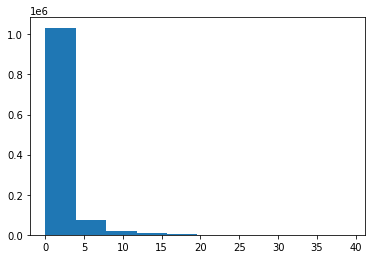

In [13]:
plt.hist(tracks_ready[tracks_ready['kneedle']<1]['eps'])
plt.plot()

In [14]:
tracks_ready[tracks_ready['kneedle']<1]['eps'].describe()

count    1.137802e+06
mean     1.348655e+00
std      2.503990e+00
min      0.000000e+00
25%      1.110695e-01
50%      4.499002e-01
75%      1.386776e+00
max      3.922471e+01
Name: eps, dtype: float64

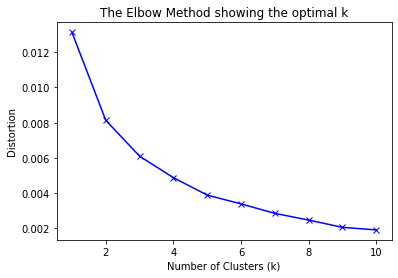

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

# Create a list to hold the distortions (inertia) for each number of clusters
distortions = []

# Generate some sample data (replace this with your actual dataset)
# X = ...

# Fit KMeans and calculate the distortions for a range of number of clusters
for k in range(1, 11):
    kmeanModel = KMeans(n_clusters=k).fit(tracks_ready['kneedle'].values.reshape(-1,1))
    kmeanModel.fit(tracks_ready['kneedle'].values.reshape(-1,1))
    distortions.append(sum(np.min(cdist(tracks_ready['kneedle'].values.reshape(-1,1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tracks_ready['kneedle'].values.reshape(-1,1).shape[0])

# Plot the elbow graph
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show() 

Короче, тут аж критерий существует для поиска оптимальной точки - тут можно посмотреть код https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

Но он ТАААААК долго считался что я решила довериться графику и теоретиечскому обоснованию что 5 кластеров - это окау

In [16]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(tracks_ready['kneedle'].values.reshape(-1,1))


KMeans(n_clusters=5)

In [17]:
tracks_ready['5 clusters for settlement level']=kmeans.labels_

разница средних в километрах между кластерами и кол-во наблюдений. Получаем 5 типов уровня оседласти с разными уровнями "разброса"

In [18]:
tracks_ready['help']=1

In [19]:
pd.pivot_table(tracks_ready,index='5 clusters for settlement level',values=('eps','help'),aggfunc={'eps':'mean','help':sum})

,eps,help
5 clusters for settlement level,,
0,2.272570,188186
1,20.831274,5560
2,5.457857,75053
3,0.364263,843347
4,10.686991,25656


In [20]:
np.median(tracks_ready[tracks_ready['5 clusters for settlement level']==0]['kneedle'])

0.01903040729989995

# For different time zones in day

In [193]:
tracks_ready.columns

Index(['id', 'start_dttm', 'end_dttm', 'centroid_wkt', 'centroid_lon',
       'centroid_lat', 'start_dttm_day', 'h3_9', 'time_spent', 'current_date',
       ...
       'num of days appear fr', 'number of visits of hex per day',
       'time_spent_avr_h', 'weekend', 'clusters_settl', 'id_check', 'kneedle',
       'eps', '5 clusters for settlement level', 'help'],
      dtype='object', length=139)

Шо имеем - для каждой части дня для eps=0.01  насчитали кучу кластеров по геолокациям. Кол-во кластеров можно сделать меньше, увеличив это значение. Может быть нужно бдет поэксперементировать, кол-во кластеров зависит от наших намерений скорее. Как мне кажется тут больше важен алгоритм и что он способен выдать, чем сам результат конекретно сейчас. 

In [26]:
np.unique(tracks_ready['final_part_of_day_in_word'])

array(['evening', 'morning', 'night', 'whole day', 'whole day end',
       'working hours'], dtype=object)

In [ ]:
#for pds in np.unique(tracks_ready['final_part_of_day_in_word']):
pds='working hours'
df_s=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word']]
X=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat']]
nbrs = NearestNeighbors(n_neighbors = 5).fit(X)
neigh_dist, neigh_ind = nbrs.kneighbors(X)
sort_neigh_dist = np.sort(neigh_dist, axis = 0)
k_dist = sort_neigh_dist[:, 2]
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, 
                    curve = "concave", direction = "increasing", online=True)
#kneedle_cuurent=kneedle.knee_y
kneedle_current=0.01 #автоматически подбирается хреново для такого кол-ва, посмотрела среднее значение из предыдущего куска кода
clusters = DBSCAN(eps = kneedle_current, min_samples = 1).fit(X)    
df_s[pds]=clusters.labels_
tracks_ready=pd.merge(tracks_ready,df_s, how='left',on=['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word'])
print(pds)



In [ ]:
for col in np.unique(tracks_ready['final_part_of_day_in_word']):
    len(np.unique(tracks_ready[col]))
    

In [ ]:
tracks_ready.to_csv('C:/Users/Asus/Downloads/tracks_ready.csv',sep=',',index=False)

Если нужно будет что то визаулизировать

In [40]:

import plotly.express as px

color_scale = [(0, 'orange'), (1,'red')]

fig1 = px.scatter_mapbox(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']], 
                        lat='centroid_lat', 
                        lon='centroid_lon', 
                        #hover_name="name", 
                        #hover_data=["name"],
                        color=clusters.labels_,
                        #color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig1.update_layout(mapbox_style="open-street-map")
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig1.show()

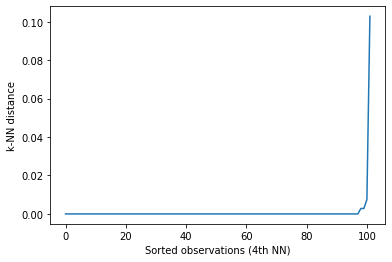

In [15]:
import matplotlib.pyplot as plt
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()